## Introduction to text analysis XI##

*Revision 2019*

**working with corpora and word frequencies**

In this notebook we explore the features of the **Brown corpus** that will help us in filtering and discovering important content from our texts

In [1]:
from nltk.corpus import brown

In [2]:
from nltk import FreqDist

In [3]:
import pandas as pd
import pickle

In [4]:
%pylab inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud

Populating the interactive namespace from numpy and matplotlib


reference function for creating a word cloud

In [5]:
def createWcloud(freqs,colormap = 'autumn'):
    wc = WordCloud(background_color="white", max_words=2000, width=1200, height=800,colormap=plt.get_cmap(colormap))
    wc.generate_from_frequencies(freqs)
    # store to file
    wc.to_file( "test.png")

    # show
    plt.figure(figsize=(16,12))
    plt.imshow(wc, interpolation='bilinear')
    #plt.tight_layout(pad=0)
    plt.axis("off")
    

the corpora has several categories ready to use

In [7]:
brown.categories()

['adventure',
 'belles_lettres',
 'editorial',
 'fiction',
 'government',
 'hobbies',
 'humor',
 'learned',
 'lore',
 'mystery',
 'news',
 'religion',
 'reviews',
 'romance',
 'science_fiction']

**computing frequencies**

get all words

In [8]:
allwords = brown.words()

In [9]:
len(allwords)

1161192

use the tools of nltk with a *lowercase* wordset

In [10]:
freqs = FreqDist([a.lower() for a in  allwords])

In [11]:
dfFreqs = pd.DataFrame.from_dict(freqs, orient='index')
dfFreqs.rename({dfFreqs.columns[0] : 'counts'},axis=1, inplace = True)

In [12]:
dfFreqs.sort_values(by='counts',ascending=False).head(10)

counts
the    69971
,      58334
.      49346
of     36412
and    28853
to     26158
a      23195
in     21337
that   10594
is     10109

**Use this *generic* dataset to filterout specialized words by difference**

Eni twitter dataset (timeline of posts) - prefiltered dataset -

In [13]:
tweets = pickle.load(open("twitter_stops_eng.pickle","rb"))


In [14]:
len(tweets)

850

In [19]:
tweets[0]

['demand',
 'for',
 'lithium',
 'rising',
 'well',
 'demand',
 'for',
 'smartdevices',
 'eniday',
 'our',
 'renewableenergies',
 'and',
 'environment',
 'laboratory']

## WordClouds of reference ##

from the brown corpus

preparing the instance of wordcloud

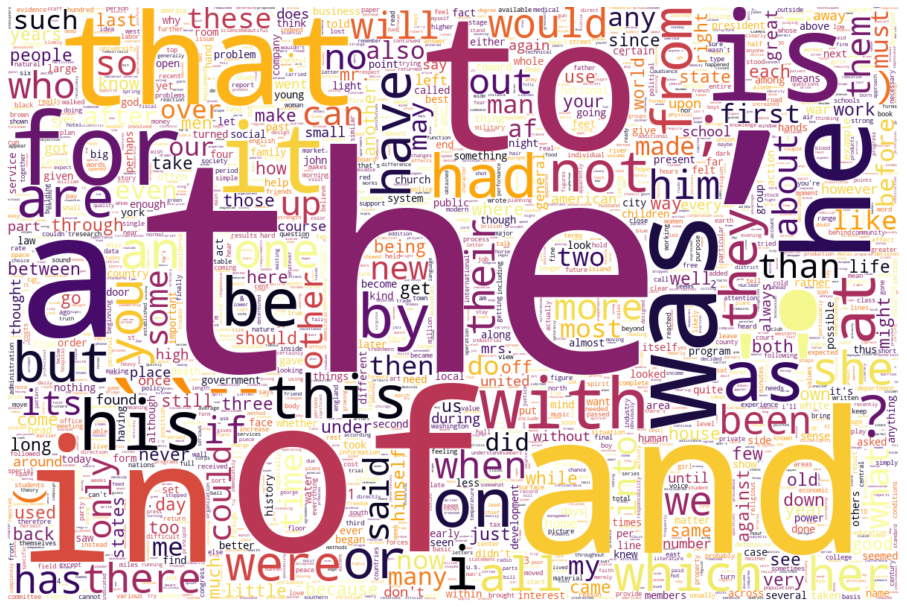

In [15]:
createWcloud(freqs,colormap = 'inferno')


**the stopwords prevail**

good news we can use those words to filterout information from the tweets ...

Let's build the frequency distribution of the tweets

In [16]:
allWordsOfTweets = []
for t in tweets:
    for w in t:
        allWordsOfTweets.append(w.lower())

In [21]:
freqTweets = FreqDist(allWordsOfTweets)

In [22]:
dfFreqsTweet = pd.DataFrame.from_dict(freqTweets, orient='index')
dfFreqsTweet.rename({dfFreqsTweet.columns[0] : 'counts'},axis=1, inplace = True)

In [23]:
dfFreqsTweet.sort_values(by='counts',ascending=False).head(10)

counts
enitweet    1184
the         1102
and          521
eni          369
eniday       343
for          298
energy       232
our          218
with         154
amp          147

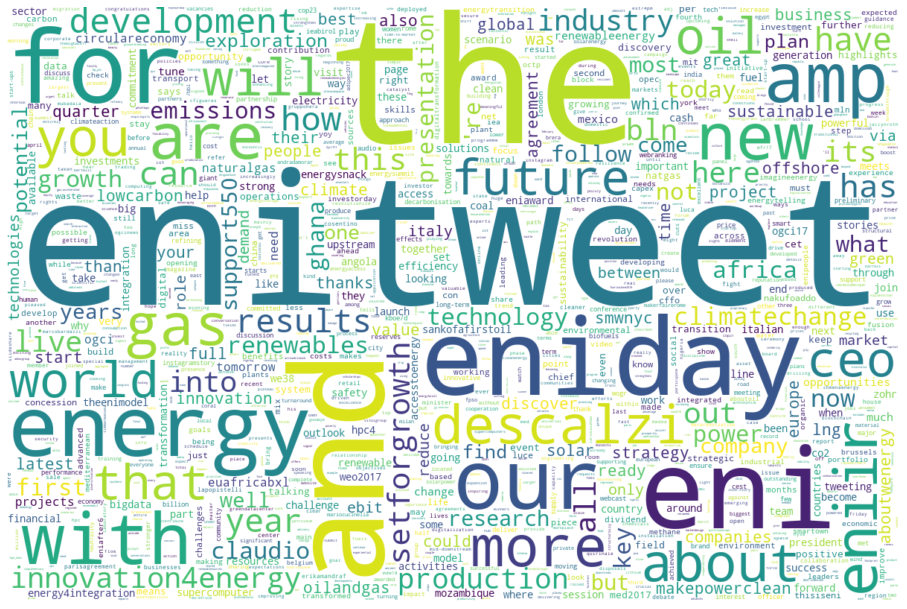

In [24]:
createWcloud(freqTweets,colormap = 'viridis')

let's make emerge the differencies

**normalize frequencies** to get the differential word that spike 

In [25]:
dfFreqsTweet = dfFreqsTweet.assign(normfreq = dfFreqsTweet.counts / dfFreqsTweet.counts.sum())

In [26]:
dfFreqsTweet.head()

counts  normfreq
demand       20  0.001039
for         298  0.015476
lithium       4  0.000208
rising        5  0.000260
well         27  0.001402

In [27]:
dfFreqs = dfFreqs.assign(normfreq = dfFreqs.counts / dfFreqs.counts.sum())

In [28]:
dfFreqs.head()

counts  normfreq
the      69971  0.060258
fulton      17  0.000015
county     155  0.000133
grand       48  0.000041
jury        67  0.000058

**basic hypothesis**

* words for a contest must have different frequency
* comparing normalized frequencies will give us the words that are far above the usual frequency

In [31]:
CompareFreq = dfFreqs.merge(dfFreqsTweet, left_index=True, right_index=True, how='right') ## we merged the two df of frequencies

In [32]:
CompareFreq.head()

counts_x  normfreq_x  counts_y  normfreq_y
demand      102.0    0.000088        20    0.001039
for        9489.0    0.008172       298    0.015476
lithium       NaN         NaN         4    0.000208
rising       62.0    0.000053         5    0.000260
well        897.0    0.000772        27    0.001402

rename columns for easier reading

In [33]:
CompareFreq.rename({'counts_x' : 'counts_brown', 'counts_y' : 'counts_twitter',
                    'normfreq_x' : 'freq_brown','normfreq_y' : 'freq_twitter'}, axis=1, inplace=True)

In [34]:
CompareFreq.head()

counts_brown  freq_brown  counts_twitter  freq_twitter
demand          102.0    0.000088              20      0.001039
for            9489.0    0.008172             298      0.015476
lithium           NaN         NaN               4      0.000208
rising           62.0    0.000053               5      0.000260
well            897.0    0.000772              27      0.001402

**filter special words (already interesting words )**

In [43]:
CompareFreqOnlyTwitter = CompareFreq[CompareFreq.freq_brown.isna()]

**now get the extra names for the domain**

In [35]:
CompareFreqNa = CompareFreq[CompareFreq.freq_brown.notna()]

In [36]:
CompareFreqNa.head()

counts_brown  freq_brown  counts_twitter  freq_twitter
demand         102.0    0.000088              20      0.001039
for           9489.0    0.008172             298      0.015476
rising          62.0    0.000053               5      0.000260
well           897.0    0.000772              27      0.001402
our           1252.0    0.001078             218      0.011322

In [37]:
CompareFreqNa = CompareFreqNa.assign(emergingwords = CompareFreqNa.freq_twitter /CompareFreqNa.freq_brown )

In [38]:
CompareFreqNa.sort_values(by='emergingwords', ascending=False).head(20)

counts_brown    freq_brown  counts_twitter  freq_twitter  \
amp                      3.0  2.583552e-06             147      0.007634   
claudio                  1.0  8.611840e-07              36      0.001870   
renewable                1.0  8.611840e-07              15      0.000779   
scenario                 1.0  8.611840e-07              13      0.000675   
portfolio                1.0  8.611840e-07               9      0.000467   
offshore                 3.0  2.583552e-06              25      0.001298   
ghana                    4.0  3.444736e-06              33      0.001714   
turnaround               1.0  8.611840e-07               6      0.000312   
milan                    1.0  8.611840e-07               6      0.000312   
global                   4.0  3.444736e-06              23      0.001194   
fuels                    1.0  8.611840e-07               5      0.000260   
upcoming                 1.0  8.611840e-07               5      0.000260   
digitalization           1.0  8.611840e-07               5      0.000260   
nigeria                  1.0  8.611840e-07               5      0.000260   
resilience               1.0  8.611840e-07               5      0.000260   
medea                    1.0  8.611840e-07               5      0.000260   
video                    2.0  1.722368e-06               9      0.000467   
angola                   3.0  2.583552e-06              13      0.000675   
audio                    2.0  1.722368e-06               8      0.000415   
worldwide                1.0  8.611840e-07               4      0.000208   

                emergingwords  
amp               2954.993924  
claudio           2171.015944  
renewable          904.589977  
scenario           783.977980  
portfolio          542.753986  
offshore           502.549987  
ghana              497.524487  
turnaround         361.835991  
milan              361.835991  
global             346.759491  
fuels              301.529992  
upcoming           301.529992  
digitalization     301.529992  
nigeria            301.529992  
resilience         301.529992  
medea              301.529992  
video              271.376993  
angola             261.325993  
audio              241.223994  
worldwide          241.223994

**amp is th & char in html ! ... drop it**

In [ ]:
CompareFreqNa = CompareFreqNa.drop('amp')

select most interesting words

In [39]:
nfreqs = CompareFreqNa[CompareFreqNa.emergingwords > 1]['emergingwords']

finally plot the data having emergingwords freq > 1

In [40]:
SpecialTerms = nfreqs.to_dict()

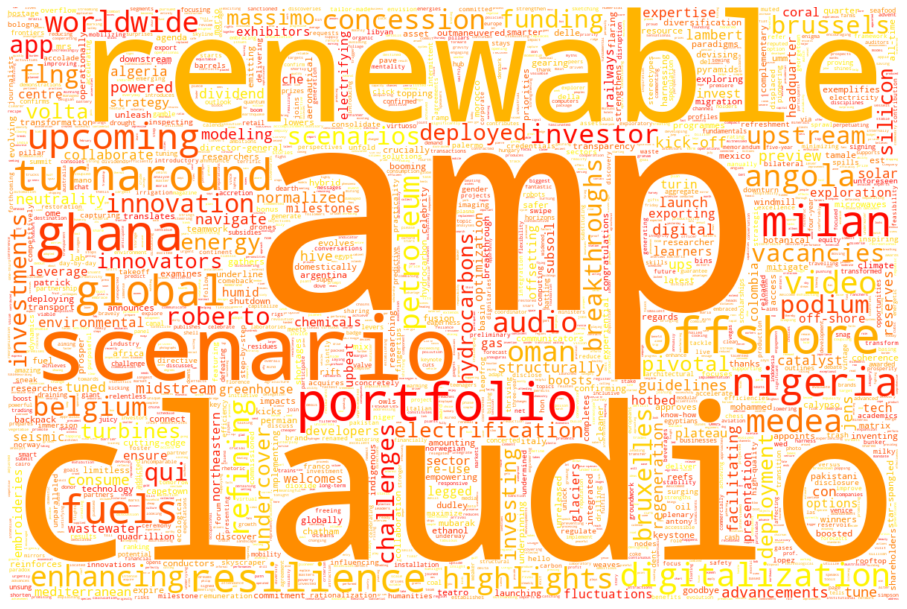

In [41]:
createWcloud(SpecialTerms,colormap = 'autumn')

**now add the remaining words (not in brown) and use the original frequency : not the ratio**

In [44]:
wordsInteresting = list(nfreqs.keys()) + list(CompareFreqOnlyTwitter.index)

remove stopwords from wordsInteresting

In [46]:
from nltk.corpus import stopwords
eng = stopwords.words('english')

In [47]:
newWords = [w for w in wordsInteresting if w not in eng]

In [48]:
len(newWords)

3558

In [49]:
len(wordsInteresting)

3587

merge data with the original frequencies

In [50]:
dfFreqsTweet.head()

counts  normfreq
demand       20  0.001039
for         298  0.015476
lithium       4  0.000208
rising        5  0.000260
well         27  0.001402

use the function "loc" (that works like a vector)

In [51]:
dfFinalTweet = dfFreqsTweet.loc[newWords]

In [52]:
freqsTwitterFinal = dfFinalTweet.counts.to_dict()

## final elaboration ##

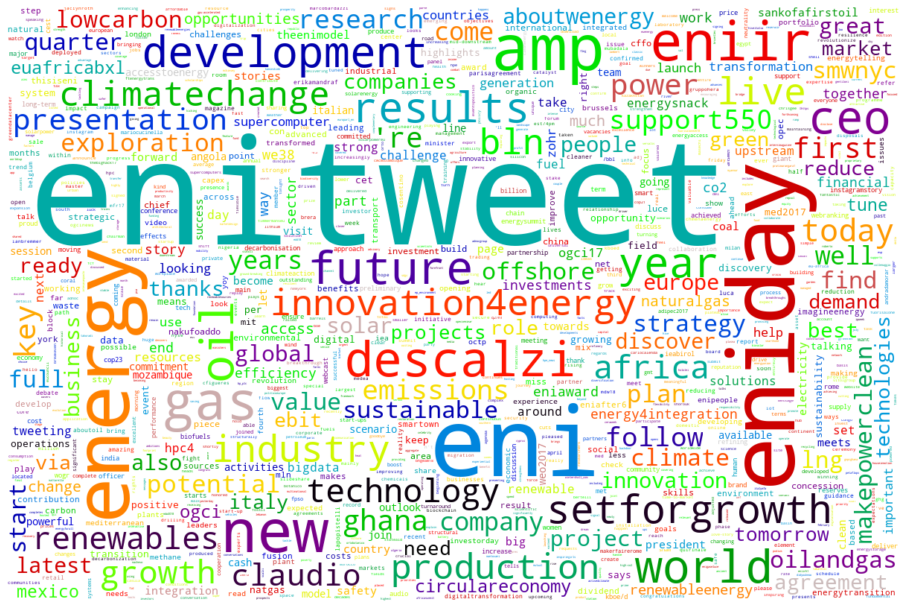

In [53]:
createWcloud(freqsTwitterFinal,colormap = 'nipy_spectral_r')

compare it with the original word cloud

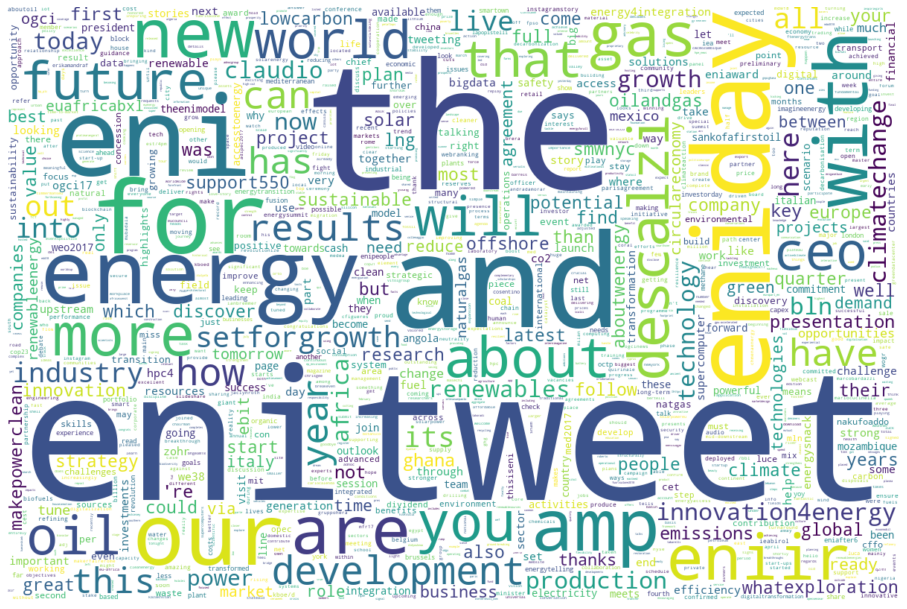

In [54]:
createWcloud(freqTweets,colormap = 'viridis')

the result is a lot less noisy !!

### Exercises ###

* apply this technique to the 20 newsgroups using the Brown corporta and/or the entire dataset as a reference.
* get the emerging words out of each corpora